---original dataset---
total samples: 45211
class 'no':  39922 (88.3%)
class 'yes': 5289 (11.7%)
imbalance ratio: 7.55:1


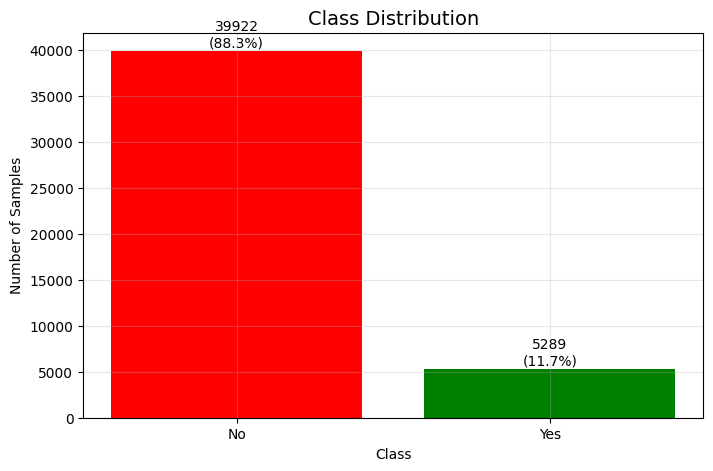


minority class samples: 5289
feature dimension: 16

Training Vanilla GAN:
Epoch 0: D_loss=1.286, G_loss=0.697
Epoch 1: D_loss=1.152, G_loss=0.934
Epoch 2: D_loss=1.131, G_loss=0.975
Epoch 3: D_loss=1.029, G_loss=1.220
Epoch 4: D_loss=0.952, G_loss=1.361
Epoch 5: D_loss=0.963, G_loss=1.293
Epoch 6: D_loss=0.871, G_loss=1.471
Epoch 7: D_loss=0.800, G_loss=1.659
Epoch 8: D_loss=0.847, G_loss=1.601
Epoch 9: D_loss=0.942, G_loss=1.402
Epoch 10: D_loss=0.769, G_loss=1.803
Epoch 11: D_loss=0.798, G_loss=1.614
Epoch 12: D_loss=0.840, G_loss=1.594
Epoch 13: D_loss=0.932, G_loss=1.434
Epoch 14: D_loss=0.832, G_loss=1.585
Epoch 15: D_loss=0.892, G_loss=1.617
Epoch 16: D_loss=0.967, G_loss=1.429
Epoch 17: D_loss=1.028, G_loss=1.270
Epoch 18: D_loss=1.035, G_loss=1.281
Epoch 19: D_loss=0.963, G_loss=1.318
Epoch 20: D_loss=1.025, G_loss=1.230
Epoch 21: D_loss=1.063, G_loss=1.308
Epoch 22: D_loss=0.968, G_loss=1.455
Epoch 23: D_loss=0.884, G_loss=1.476
Epoch 24: D_loss=0.881, G_loss=1.560
Epoch 25: 

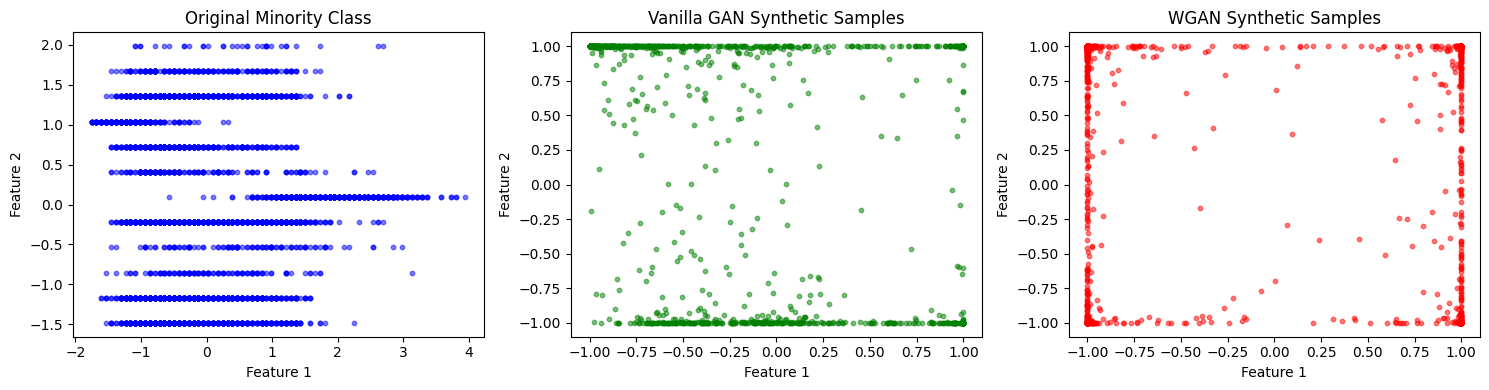

-------------------------------------------------------------------------------------------
Dataset                   Total      Class No        Class Yes       Ratio (No:Yes)
-------------------------------------------------------------------------------------------
Original                  45211      39922 (88.3%)  5289 (11.7%)  7.55:1
Vanilla GAN Balanced      79844      39922 (50.0%)  39922 (50.0%)  1.00:1
WGAN Balanced             79844      39922 (50.0%)  39922 (50.0%)  1.00:1

  original (imbalanced):
    Accuracy:   0.8998
    Precision:  0.6058
    Recall:     0.4115
    F1-Score:   0.4901
    AUC-ROC:    0.8995

  2. vanilla GAN (balanced):
    Accuracy:   0.9383
    Precision:  0.9713
    Recall:     0.9033
    F1-Score:   0.9361
    AUC-ROC:    0.9829

  WGAN (balanced):
    Accuracy:   0.9382
    Precision:  0.9682
    Recall:     0.9062
    F1-Score:   0.9362
    AUC-ROC:    0.9831
------------------------------------------------------------------------------------------

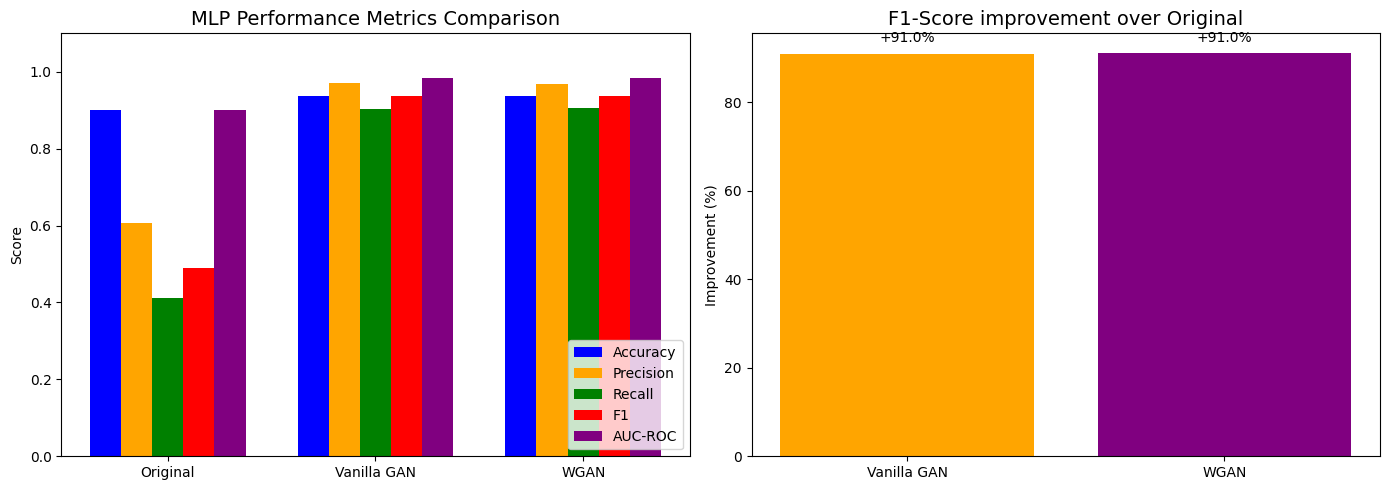

Vanilla GAN improvement: +91.0% F1-Score
WGAN improvement: +91.0% F1-Score
best performing GAN: WGAN
----OVERFITTING CHECK----

Original:
  training accuracy: 0.907
  testing accuracy:  0.900
  difference:        0.0068
----OVERFITTING CHECK----

Vanilla GAN:
  training accuracy: 0.941
  testing accuracy:  0.938
  difference:        0.0030
----OVERFITTING CHECK----

WGAN:
  training accuracy: 0.941
  testing accuracy:  0.938
  difference:        0.0025


In [2]:
#################################################################
# I wrote the code in colab so it's recommended to run it there
#################################################################

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# ********************** Step 1: Dataset Selection *************************

df = pd.read_csv('bank-full_sp.csv', sep=',')

# class distribution
no_count = df[df['y'] == 'no'].shape[0]
yes_count = df[df['y'] == 'yes'].shape[0]
total = df.shape[0]
print("---original dataset---")
print(f"total samples: {total}")
print(f"class 'no':  {no_count} ({no_count/total*100:.1f}%)")
print(f"class 'yes': {yes_count} ({yes_count/total*100:.1f}%)")
print(f"imbalance ratio: {no_count/yes_count:.2f}:1")

# bar chart
plt.figure(figsize=(8, 5))
plt.bar(['No', 'Yes'], [no_count, yes_count], color=['red', 'green'])
plt.title('Class Distribution', fontsize=14)
plt.ylabel('Number of Samples')
plt.xlabel('Class')
plt.text(0, no_count + 500, f'{no_count}\n({no_count/total*100:.1f}%)', ha='center')
plt.text(1, yes_count + 500, f'{yes_count}\n({yes_count/total*100:.1f}%)', ha='center')
plt.grid(True, alpha=0.3)
plt.savefig('class_distribution.png', dpi=300)
plt.show()


# ****************** Step 2: GAN Implementation ************************

# extract minority class
minority_df = df[df['y'] == 'yes'].copy()

X_minority = minority_df.drop('y', axis=1) # keeps only the features and drops the target

# encoding categorical columns (categorical to numerical)
categorical_columns = X_minority.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    X_minority[col] = le.fit_transform(X_minority[col])

# normalize data
X_minority = (X_minority - X_minority.mean()) / (X_minority.std() + 1e-8) # 1e-8 prevents division by zero

# convert to tensor
minority_tensor = torch.FloatTensor(X_minority.values) # # PyTorch only works with tensors not DataFrames
feature_dim = minority_tensor.shape[1] # number of features


print(f"\nminority class samples: {len(minority_tensor)}")
print(f"feature dimension: {feature_dim}")

# DataLoader that feeds data in batches of 64
dataloader = DataLoader(TensorDataset(minority_tensor), batch_size=64, shuffle=True) # shuffle = true so that the model doesn’t memorize order

class VanillaGAN(nn.Module):
    def __init__(self):
        super().__init__()
        # generator implementation
        self.generator = nn.Sequential(
            nn.Linear(100, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, feature_dim), nn.Tanh()
        )
        # discriminator implementation
        self.discriminator = nn.Sequential(
            nn.Linear(feature_dim, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 128), nn.LeakyReLU(0.2), # leakyRelu helps during training by allowing small negative values to prevent dead neurons problem
            nn.Linear(128, 1), nn.Sigmoid() # output close to 1 means real and close to 0 means fake
        )

    def generate(self, n):
        device = next(self.parameters()).device # whether model is using CPU or GPU
        z = torch.randn(n, 100, device=device) # random noise (input to generator)
        return self.generator(z) # transforms noise into fake data


class WGAN(nn.Module):
    def __init__(self):
        super().__init__()
        # same as vanilla gan
        self.generator = nn.Sequential(
            nn.Linear(100, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, feature_dim), nn.Tanh()
        )
        # critic (not like discriminator) : scores data quality
        self.critic = nn.Sequential(
            nn.Linear(feature_dim, 256), nn.LeakyReLU(0.2), # extracts features
            nn.Linear(256, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 1)  # real number output (no sigmoid) for Wasserstein distance
        )

    def generate(self, n):
        device = next(self.parameters()).device
        z = torch.randn(n, 100, device=device)
        return self.generator(z)


def train_vanilla_gan(model, name, epochs=150):
    print(f"\nTraining {name}:")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU if available , else CPU
    model.to(device)

    # using adam optimizer for generator and discriminator (hyperparameters are standard for GANs)
    g_optim = optim.Adam(model.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optim = optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss() # using binary cross entropy because discriminator outputs probabilities

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0

        # gets a batch of real minority class samples
        for real_data in dataloader:
            real_data = real_data[0].to(device)
            batch_size = real_data.size(0)

           # stabilizes GAN training by preventing the discriminator from learning too fast and leading to vanishing gradients (generator learns from the discriminator’s gradients)
            real_labels = torch.ones(batch_size, 1).to(device) * 0.9
            fake_labels = torch.zeros(batch_size, 1).to(device) + 0.1

            # train discriminator
            d_optim.zero_grad() # clears old gradients
            real_out = model.discriminator(real_data) # passing real data to discriminator
            d_real_loss = criterion(real_out, real_labels)

            z = torch.randn(batch_size, 100).to(device) # creating random noise
            fake_data = model.generator(z) # creating fake data
            fake_out = model.discriminator(fake_data.detach()) # detach() to stop gradients from flowing to the generator so that only the discriminator learns(without 'help')
            d_fake_loss = criterion(fake_out, fake_labels)

            # updating discriminator weights
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optim.step()

            # train generator
            g_optim.zero_grad() # clears old gradients
            fake_out = model.discriminator(fake_data) # generator tries to trick the discriminator into thinking fake data is real

            # updates generator weights
            g_loss = criterion(fake_out, real_labels)
            g_loss.backward()
            g_optim.step()

            # to compute average loss per epoch
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            num_batches += 1
        print(f"Epoch {epoch}: D_loss={epoch_d_loss/num_batches:.3f}, G_loss={epoch_g_loss/num_batches:.3f}")

    print(f"{name} training is completed")
    return model

def train_wgan(model, name, epochs=150, n_critic=5):
    print(f"\nTraining {name}:")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # chose RMSprop optimizer (better stability than adam)
    g_optim = optim.RMSprop(model.generator.parameters(), lr=0.00005)
    c_optim = optim.RMSprop(model.critic.parameters(), lr=0.00005)

    # weight clipping to enforce Lipschitz constraint (WGAN requirement to prevent exploding gradients)
    clip_value = 0.01

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_c_loss = 0
        num_batches = 0

        for real_data in dataloader:
            real_data = real_data[0].to(device)
            batch_size = real_data.size(0)

            # Train critic more times than generator (n_critic times)
            for _ in range(n_critic):
                c_optim.zero_grad()

                # real data
                real_out = model.critic(real_data)

                # fake data
                z = torch.randn(batch_size, 100).to(device)
                fake_data = model.generator(z)
                fake_out = model.critic(fake_data.detach())

                # critic loss (Wasserstein loss) maximizes distance between real and fake scores
                c_loss = -(torch.mean(real_out) - torch.mean(fake_out))
                c_loss.backward()
                c_optim.step()

                # weight clipping for Lipschitz constraint
                for p in model.critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            # train generator
            g_optim.zero_grad() # clears old gradients
            fake_out = model.critic(fake_data)
            g_loss = -torch.mean(fake_out) # generator tries to increase critic’s score for fake data (fooling the critic)
            g_loss.backward()
            g_optim.step()

            # to calculate average loss per epoch
            epoch_g_loss += g_loss.item()
            epoch_c_loss += c_loss.item()
            num_batches += 1
        print(f"epoch {epoch}: C_loss={epoch_c_loss/num_batches:.3f}, G_loss={epoch_g_loss/num_batches:.3f}")

    print(f"{name} training is completed")
    return model


# train the gans :
vanilla_gan = train_vanilla_gan(VanillaGAN(), "Vanilla GAN", epochs=150)
wgan = train_wgan(WGAN(), "WGAN", epochs=150, n_critic=5)


# to get the number of synthetic samples needed to balance classes (yes and no)
n_needed = no_count - yes_count

# sets model to evaluation mode (turns off training-specific behavior) for generating data
vanilla_gan.eval()
wgan.eval()

with torch.no_grad(): # as no gradients needed (faster)
    vanilla_synthetic = vanilla_gan.generate(n_needed).cpu().numpy()
    wgan_synthetic = wgan.generate(n_needed).cpu().numpy()

print(f"generated {n_needed} synthetic samples from each GAN")


print("\nvisualizing generated samples:")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], alpha=0.5, s=10, color='blue')
ax1.set_title('Original Minority Class')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# plots first 1000 synthetic samples from Vanilla GAN
ax2.scatter(vanilla_synthetic[:1000, 0], vanilla_synthetic[:1000, 1], alpha=0.5, s=10, color='green')
ax2.set_title('Vanilla GAN Synthetic Samples')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')


# plots first 1000 synthetic samples from WGAN
ax3.scatter(wgan_synthetic[:1000, 0], wgan_synthetic[:1000, 1], alpha=0.5, s=10, color='red')
ax3.set_title('WGAN Synthetic Samples')
ax3.set_xlabel('Feature 1')
ax3.set_ylabel('Feature 2')

plt.tight_layout()
plt.savefig('generated_samples.png', dpi=300)
plt.show()

# **************** Step 3: Data Augmentation & Classification *************************

# create balanced datasets

vanilla_synthetic_df = pd.DataFrame(vanilla_synthetic, columns=X_minority.columns) # convert Vanilla GAN synthetic samples to a DataFrame
vanilla_synthetic_df['y'] = 'yes'# label "yes" for synthetic samples
balanced_vanilla = pd.concat([df, vanilla_synthetic_df], ignore_index=True) # combines original dataset and synthetic samples to get a balanced dataset

# the same for WGAN
wgan_synthetic_df = pd.DataFrame(wgan_synthetic, columns=X_minority.columns)
wgan_synthetic_df['y'] = 'yes'
balanced_wgan = pd.concat([df, wgan_synthetic_df], ignore_index=True)


# calculate class distribution for all datasets
def get_class_distribution(dataframe):
    total = dataframe.shape[0]
    no_count = dataframe[dataframe['y'] == 'no'].shape[0]
    yes_count = dataframe[dataframe['y'] == 'yes'].shape[0]
    return {
        'total': total,
        'no_count': no_count,
        'yes_count': yes_count,
        'no_percent': (no_count/total*100),
        'yes_percent': (yes_count/total*100),
        'ratio': no_count/yes_count if yes_count > 0 else float('inf')
    }

# get distributions
orig_dist = get_class_distribution(df)
vanilla_dist = get_class_distribution(balanced_vanilla)
wgan_dist = get_class_distribution(balanced_wgan)


print("-------------------------------------------------------------------------------------------")
print(f"{'Dataset':<25} {'Total':<10} {'Class No':<15} {'Class Yes':<15} {'Ratio (No:Yes)'}")
print("-------------------------------------------------------------------------------------------")
print(f"{'Original':<25} {orig_dist['total']:<10} "
      f"{orig_dist['no_count']} ({orig_dist['no_percent']:.1f}%)  "
      f"{orig_dist['yes_count']} ({orig_dist['yes_percent']:.1f}%)  "
      f"{orig_dist['ratio']:.2f}:1")

print(f"{'Vanilla GAN Balanced':<25} {vanilla_dist['total']:<10} "
      f"{vanilla_dist['no_count']} ({vanilla_dist['no_percent']:.1f}%)  "
      f"{vanilla_dist['yes_count']} ({vanilla_dist['yes_percent']:.1f}%)  "
      f"{vanilla_dist['ratio']:.2f}:1")

print(f"{'WGAN Balanced':<25} {wgan_dist['total']:<10} "
      f"{wgan_dist['no_count']} ({wgan_dist['no_percent']:.1f}%)  "
      f"{wgan_dist['yes_count']} ({wgan_dist['yes_percent']:.1f}%)  "
      f"{wgan_dist['ratio']:.2f}:1")


def prepare_data(data_df):
    X = data_df.drop('y', axis=1).copy() # extract features
    y = data_df['y'].copy() # extract target

    y = (y == 'yes').astype(int) # converts labels to 0/1 integers

    # converting categorical features to numerical features using LabelEncoder
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y


# prepares original and augmented datasets for training :
X_orig, y_orig = prepare_data(df)
X_vanilla, y_vanilla = prepare_data(balanced_vanilla)
X_wgan, y_wgan = prepare_data(balanced_wgan)

def train_and_evaluate_mlp(X, y, name):
    # splits dataset into train 70% and test 30% while keeping class distribution (stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    mlp = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=256,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=300,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )

    mlp.fit(X_train, y_train)


    # predicts labels and probabilities on the test set
    y_pred = mlp.predict(X_test)
    y_prob = mlp.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n  {name}:")
    print(f"    Accuracy:   {acc:.4f}")
    print(f"    Precision:  {precision:.4f}")
    print(f"    Recall:     {recall:.4f}")
    print(f"    F1-Score:   {f1:.4f}")
    print(f"    AUC-ROC:    {auc:.4f}")

    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}


orig_results = train_and_evaluate_mlp(X_orig, y_orig, "original (imbalanced)")
vanilla_results = train_and_evaluate_mlp(X_vanilla, y_vanilla, "2. vanilla GAN (balanced)")
wgan_results = train_and_evaluate_mlp(X_wgan, y_wgan, "WGAN (balanced)")

# ***************************** Step 4: Evaluation ***************************

print("-----------------------------------------------------------------------------------------------------------------------")
print(f"{'Dataset':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC-ROC':<10}")
print("-----------------------------------------------------------------------------------------------------------------------")
print(f"{'Original':<25} {orig_results['accuracy']:<10.4f} {orig_results['precision']:<10.4f} "
      f"{orig_results['recall']:<10.4f} {orig_results['f1']:<10.4f} {orig_results['auc']:<10.4f}")
print(f"{'Vanilla GAN':<25} {vanilla_results['accuracy']:<10.4f} {vanilla_results['precision']:<10.4f} "
      f"{vanilla_results['recall']:<10.4f} {vanilla_results['f1']:<10.4f} {vanilla_results['auc']:<10.4f}")
print(f"{'WGAN':<25} {wgan_results['accuracy']:<10.4f} {wgan_results['precision']:<10.4f} "
      f"{wgan_results['recall']:<10.4f} {wgan_results['f1']:<10.4f} {wgan_results['auc']:<10.4f}")

print("\nimprovement over original:")
print("---------------------------------------------------------------")
print(f"{'Metric':<15} {'Vanilla GAN':<15} {'WGAN':<15}")
print("---------------------------------------------------------------")

metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for metric, name in zip(metrics, metric_names):
    vanilla_improvement = ((vanilla_results[metric] - orig_results[metric]) / orig_results[metric]) * 100
    wgan_improvement = ((wgan_results[metric] - orig_results[metric]) / orig_results[metric]) * 100
    print(f"{name:<15} {vanilla_improvement:>+7.1f}%{'':<7} {wgan_improvement:>+7.1f}%")

print("\nvisualizing performance metrics comparison:-")

# performance comparison :-

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

datasets = ['Original', 'Vanilla GAN', 'WGAN']
x = np.arange(len(datasets))
width = 0.15

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']
colors = ['blue', 'orange', 'green', 'red', 'purple']

for i, (metric, label, color) in enumerate(zip(metrics_to_plot, metric_labels, colors)):
    values = [orig_results[metric], vanilla_results[metric], wgan_results[metric]]
    ax1.bar(x + (i-2)*width, values, width, label=label, color=color)

ax1.set_title('MLP Performance Metrics Comparison', fontsize=14)
ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.legend(loc='lower right')
ax1.set_ylim([0, 1.1])

# F1 improvements
vanilla_f1_improvement = ((vanilla_results['f1'] - orig_results['f1']) / orig_results['f1']) * 100
wgan_f1_improvement = ((wgan_results['f1'] - orig_results['f1']) / orig_results['f1']) * 100

bars = ax2.bar(['Vanilla GAN', 'WGAN'], [vanilla_f1_improvement, wgan_f1_improvement],
               color=['orange', 'purple'])
ax2.set_title('F1-Score improvement over Original', fontsize=14)
ax2.set_ylabel('Improvement (%)')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# value labels on bars:-
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:+.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300)
plt.show()

print(f"Vanilla GAN improvement: +{vanilla_f1_improvement:.1f}% F1-Score")
print(f"WGAN improvement: +{wgan_f1_improvement:.1f}% F1-Score")
print(f"best performing GAN: {'Vanilla GAN' if vanilla_results['f1'] > wgan_results['f1'] else 'WGAN'}")

# ****************** OVERFITTING CHECK*******************************************

def quick_check(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    mlp = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=256,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=300,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )

    mlp.fit(X_train, y_train)

    train_acc = mlp.score(X_train, y_train)
    test_acc = mlp.score(X_test, y_test)

    return train_acc, test_acc


# check each dataset
datasets = [
    ("Original", X_orig, y_orig),
    ("Vanilla GAN", X_vanilla, y_vanilla),
    ("WGAN", X_wgan, y_wgan)
]

for name, X, y in datasets:
    train_acc, test_acc = quick_check(X, y, name)
    diff = train_acc - test_acc
    print("----OVERFITTING CHECK----")
    print(f"\n{name}:")
    print(f"  training accuracy: {train_acc:.3f}")
    print(f"  testing accuracy:  {test_acc:.3f}")
    print(f"  difference:        {diff:.4f}")